In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import helper_methods
import yfinance

In [89]:
# TO DO: In a different file, find two cointegrated stocks. Those two stocks will replace KO and PEP

# Pt 1 of this file visualizes the cointegration of the 2 stocks. Pt 2 of this file researches buy and sell signals

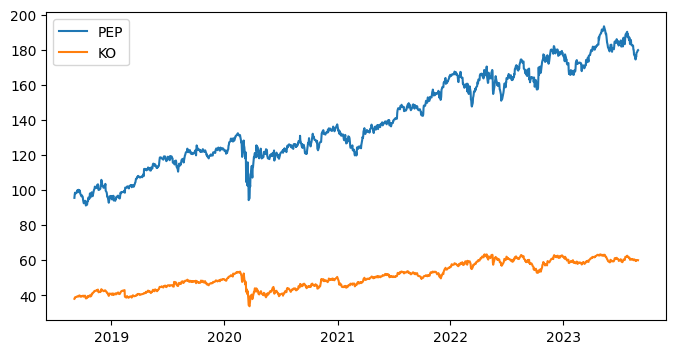

In [90]:
# Pt 1: Begin Visualizing cointegration

# Plot the two assets
df_1 = helper_methods.get_stock_prices("PEP", "2018-09-01", "2023-08-31")
df_2 = helper_methods.get_stock_prices("KO", "2018-09-01", "2023-08-31")
stock_1 = df_1['Close']
stock_2 = df_2['Close']

# Note: need to change the labels
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(stock_1, label = 'PEP')
ax.plot(stock_2, label = 'KO')
ax.legend()
plt.show()

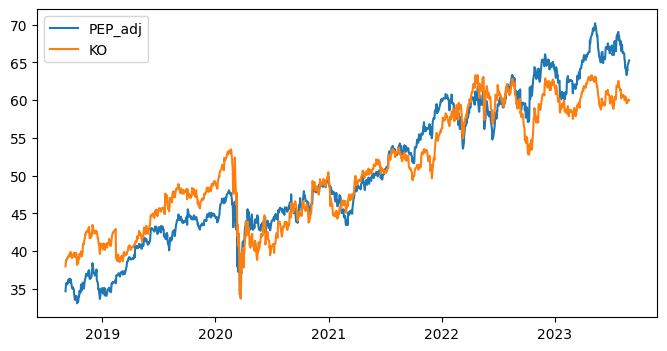

In [91]:
# We can see that PEP and KO roughly move together, but to see this better, let's normalize them to see them right next to each other
stock_1_adjusted = stock_1 / (np.mean(stock_1) / np.mean(stock_2))

# Note: need to change labels
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(stock_1_adjusted, label = 'PEP_adj')
ax.plot(stock_2, label = 'KO')
ax.legend()
plt.show()

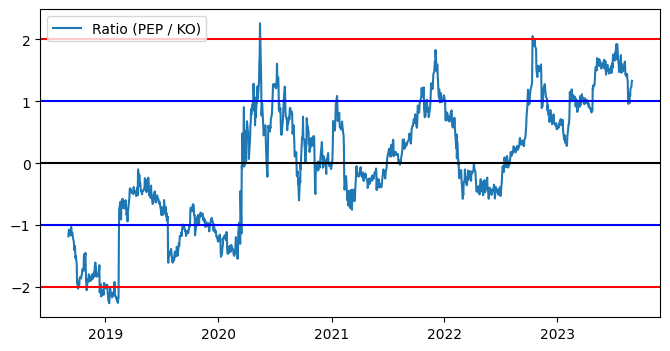

In [92]:
# Use ratios to calculate spread
ratio = stock_1 / stock_2

# Normalize the series
z_score = (ratio - ratio.mean()) / ratio.std()

# Note: need to change labels
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(z_score, label = 'Ratio (PEP / KO)')
plt.axhline(z_score.mean(), color = 'black')

# 68% of the data lies within 1 standard deviation
plt.axhline(1.0, color = 'blue')
plt.axhline(-1.0, color = 'blue')

# 95% of data lies within 2 standard deviations from mean
plt.axhline(2.0, color = 'red')
plt.axhline(-2.0, color = 'red')

ax.legend()
plt.show()


# This ratio appears stationary (not entirely, but if we find a better cointegrated pair it should appear more stationary)
# Note that this visualization does have look ahead bias. For example, the z score threshold in 2020 takes into account data from 2022.

In [93]:
# Pt 2: Begin signal research

# Split train and test data
train = ratio[0:round(.8*len(ratio))]
test = ratio[round(.8*len(ratio)):]

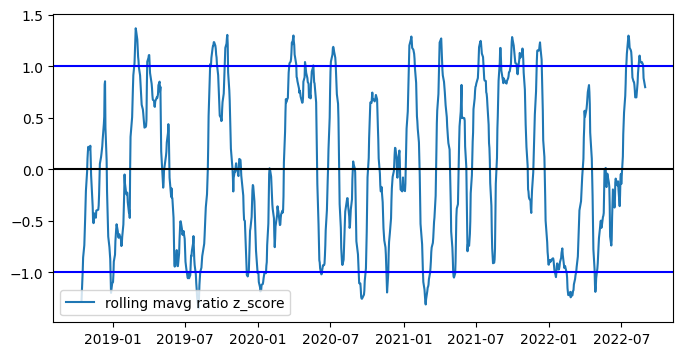

In [233]:
# Adjust the graph to moving average to avoid look ahead bias (we might want to adjust the windows later)

# 1 day moving avg represents our current mean
mavg_10_day = train.rolling(window=10).mean()

# 30 day moving avg represents our historical mean
mavg_30_day = train.rolling(window=30).mean()
std_30_day = train.rolling(window=30).std()

# Calculate z-score for difference between current and historical mean
z_score_30vs10 = (mavg_10_day - mavg_30_day) / std_30_day

# Plot new graph based off moving avg
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(z_score_30vs10, label = 'rolling mavg ratio z_score')
plt.axhline(0, color = 'black')
plt.axhline(1.0, color = 'blue')
plt.axhline(-1.0, color = 'blue')
plt.legend()
plt.show()

# Note that this graph's signals don't look as powerful as the previous graph, but that is because we don't have look ahead bias here
# Also note that this data will not follow the 68/95/99 rule because we are comparing the current moving average to the standard deviation of a longer moving average.
# Ratios further from a mean still signal divergence, but just not at the exact percentages of 68/95/99


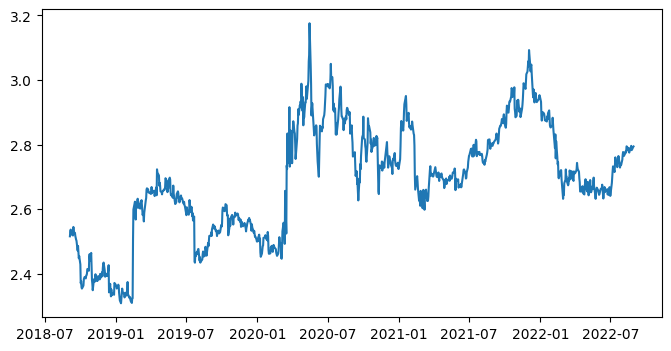

In [234]:
# With the graph above, we will want to trade the spread when the rolling moving average ratio moves outside the blue band.
# If the value is above the band, that means that stock_1 (PEP) is overvalued compared to stock_2 (KO), so we will sell the spread, which means short stock_1 and long stock_2
# If the value is below the band, that means that stock_1 (PEP) is undervalued compared to stock_2 (KO), so we will buy the spread, which means long stock_1 and short stock_2

trade_threshold = 1 # Z_score threshold to trade
stop_threshold = 2 # Z_score threshold to stop strategy

trades_train = train.copy()
trades_train[z_score_30vs10 > trade_threshold] = -1 # when the z-score is above 1, sell the spread
trades_train[z_score_30vs10 < -trade_threshold] = 1 # when the z-score is below -1, buy the spread
trades_train[(z_score_30vs10 >= -trade_threshold) & (z_score_30vs10 <= trade_threshold) | np.isnan(z_score_30vs10)] = 0 # otherwise, do nothing

#stop the strategy if we cross a certain threshold
crossed_index = ((z_score_30vs10 > stop_threshold) | (z_score_30vs10 < -stop_threshold)).idxmax()
if not pd.isnull(crossed_index):
    trades_train[crossed_index:] = 100 # If our trade signal is 100, that means we stop our strategy

# TO DO: add a stop loss if this gets too far away from the mean. Maybe 3.5 SDs away?

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(train, label='z_score_30vs10')
ax.scatter(train.index[trades_train == 1], train[trades_train == 1], color='green', marker='^', label='Buy (1)')
ax.scatter(train.index[trades_train == -1], train[trades_train == -1], color='red', marker='v', label='Sell (-1)')
plt.show()

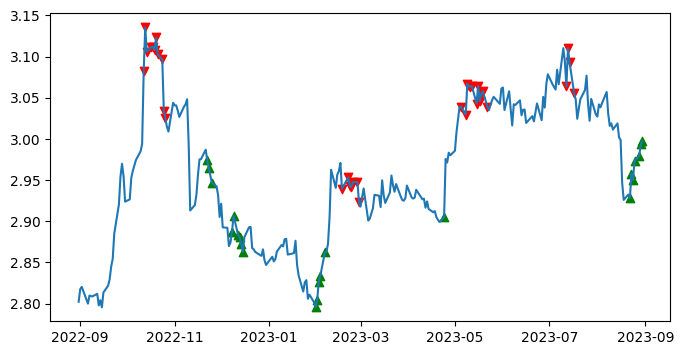

In [235]:
#Repeat with test
mavg_10_day = test.rolling(window=10).mean()
mavg_30_day = test.rolling(window=30).mean()
std_30_day = test.rolling(window=30).std()
z_score_30vs10 = (mavg_10_day - mavg_30_day) / std_30_day

trades_test = test.copy()
trades_test[z_score_30vs10 > trade_threshold] = -1 # when the z-score is above 1, sell the spread
trades_test[z_score_30vs10 < -trade_threshold] = 1 # when the z-score is below -1, buy the spread
trades_test[(z_score_30vs10 >= -trade_threshold) & (z_score_30vs10 <= trade_threshold) | np.isnan(z_score_30vs10)] = 0 # otherwise, do nothing
#stop the strategy if we cross a certain threshold
crossed_index = ((z_score_30vs10 > stop_threshold) | (z_score_30vs10 < -stop_threshold)).idxmax()
if not pd.isnull(crossed_index):
    trades_train[crossed_index:] = 100 # If our trade signal is 100, that means we stop our strategy


In [236]:
# TO DO: make a function that calculates profit, add stop loss on test set
# Let's assume we can buy fractional shares, and we long / short $100 of each stock during each signal.

trades = trades_test

daily_profits = pd.DataFrame(index=trades.index, columns=['Profit'])
daily_profits['Profit'] = 0.0  # Initialize daily profits to zero
daily_profits['Position_Stock_1'] = 0.0  # Initialize positions to zero
daily_profits['Position_Stock_2'] = 0.0

balance = 0 # Initial balance of 0
position_stock_1 = 0
position_stock_2 = 0
next_day_position_stock_1 = 0 
next_day_position_stock_2 = 0
investment_per_stock = 100 # $100 to invest in each stock

# Simulate the trading strategy and calculate daily profits
for date in trades.index:
    trade_signal = trades.loc[date]
    
    # Calculate the number of shares to buy/sell
    stock_1_shares = investment_per_stock / stock_1.loc[date]
    stock_2_shares = investment_per_stock / stock_2.loc[date]

    if trade_signal == 1:
        # Short $100 of stock_1 and long $100 of stock_2
        next_day_position_stock_1 -= stock_1_shares
        next_day_position_stock_2 += stock_2_shares
    elif trade_signal == -1:
        # Long $100 of stock_1 and short $100 of stock_2
        next_day_position_stock_1 += stock_1_shares
        next_day_position_stock_2 -= stock_2_shares

    # Calculate the daily profit based on positions and stock price changes
    daily_profit_stock_1 = position_stock_1 * (stock_1.loc[date] - stock_1.shift(1).loc[date])
    daily_profit_stock_2 = position_stock_2 * (stock_2.loc[date] - stock_2.shift(1).loc[date])
    daily_profit = daily_profit_stock_1 + daily_profit_stock_2
    # print(daily_profit)
    # print(balance)

    # Update the balance with daily profit
    if not np.isnan(daily_profit):
        balance += daily_profit

    # Update the daily profit and positions in the DataFrame
    daily_profits.loc[date, 'Profit'] = float(daily_profit)
    daily_profits.loc[date, 'Position_Stock_1'] = float(position_stock_1)
    daily_profits.loc[date, 'Position_Stock_2'] = float(position_stock_2)
    daily_profits.loc[date, 'Cumulative Profit'] = balance

    print(date, trade_signal, stock_1.loc[date], stock_2.loc[date], position_stock_1, position_stock_2,
          daily_profit_stock_1, daily_profit_stock_2, daily_profit, balance)


    # Update positions for the next day
    position_stock_1 = next_day_position_stock_1
    position_stock_2 = next_day_position_stock_2

    # Close all positions on last day or if we encounter stop loss
    final_profit = balance + (stock_1_shares * stock_1.get(date, 0)) + (stock_2_shares * stock_2.get(date, 0))

print(daily_profits)
print(final_profit)


2022-08-31 00:00:00-04:00 0.0 166.57408142089844 59.440975189208984 0 0 -0.0 -0.0 -0.0 0.0
2022-09-01 00:00:00-04:00 0.0 168.2581329345703 59.720306396484375 0 0 0.0 0.0 0.0 0.0
2022-09-02 00:00:00-04:00 0.0 166.1262969970703 58.90156555175781 0 0 -0.0 -0.0 -0.0 0.0
2022-09-06 00:00:00-04:00 0.0 165.0068359375 58.93046188354492 0 0 -0.0 0.0 0.0 0.0
2022-09-07 00:00:00-04:00 0.0 168.64747619628906 60.0189094543457 0 0 0.0 0.0 0.0 0.0
2022-09-08 00:00:00-04:00 0.0 168.0828857421875 59.83589553833008 0 0 -0.0 -0.0 -0.0 0.0
2022-09-09 00:00:00-04:00 0.0 168.6182861328125 60.02853775024414 0 0 0.0 0.0 0.0 0.0
2022-09-12 00:00:00-04:00 0.0 169.28021240234375 60.20191955566406 0 0 0.0 0.0 0.0 0.0
2022-09-13 00:00:00-04:00 0.0 162.96263122558594 58.24656295776367 0 0 -0.0 -0.0 -0.0 0.0
2022-09-14 00:00:00-04:00 0.0 164.19888305664062 58.5547981262207 0 0 0.0 0.0 0.0 0.0
2022-09-15 00:00:00-04:00 0.0 161.4732666015625 57.759193420410156 0 0 -0.0 -0.0 -0.0 0.0
2022-09-16 00:00:00-04:00 0.0 162.5

In [210]:
pd.set_option('display.max_rows', None)


# df = pd.DataFrame({
#     'Stock_1': stock_1,
#     'Stock_2': stock_2,
#     'Trades': trades,
#     'Profit': daily_profits['Profit'],
#     'Position_Stock_1': position_stock_1,  # Add position for stock_1
#     'Position_Stock_2': position_stock_2   # Add position for stock_2
# })
# print(stock_1)

